In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import plotly.express as px
import plotly.io as pio

from pathlib import Path
import pandas as pd
import itertools

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd6"
base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

# base_path = "/data/saturation/central_composite_design/ccd9"
# base_path_holdout = "/data/saturation/central_composite_design/ccd9_holdout"

ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage", "n_craters_in_study_region_median"]
iv_labels = {
    "slope": "$b$",
    "effective_radius_multiplier": "$E_{mult}$",
    "r_stat_multiplier": "$E_{ratio}$",
    "min_rim_percentage": "$M_r$",
    "n_craters_in_study_region_median": "$N_S$",
    "areal_density_median": "Median $A_d$",
}

In [3]:
stats_df = pd.concat([
    pd.read_csv(f"{base_path}/post_saturation_statistics.csv"),
    pd.read_csv(f"{base_path_holdout}/post_saturation_statistics.csv"),
], axis=0)
stats_df.head()

,simulation_id,slope,r_stat_multiplier,effective_radius_multiplier,min_rim_percentage,areal_density_5_percentile,areal_density_10_percentile,areal_density_15_percentile,areal_density_20_percentile,areal_density_25_percentile,...,n_craters_added_in_study_region_80_percentile,n_craters_added_in_study_region_85_percentile,n_craters_added_in_study_region_90_percentile,n_craters_added_in_study_region_95_percentile,n_craters_added_in_study_region_99_percentile,n_craters_added_in_study_region_median,n_craters_added_in_study_region_min,n_craters_added_in_study_region_max,n_craters_added_in_study_region_mean,n_craters_added_in_study_region_stdev
0,26,0.994019,2.963085,1.703002,0.376117,0.295262,0.295268,0.295855,0.295893,0.295921,...,249990,249993,249995,249998,250000,249975,249951,250000,249975.5,14.57738
1,29,1.012552,2.979334,1.903229,0.379152,0.147481,0.147560,0.147642,0.148185,0.148214,...,320240,320243,320245,320248,320250,320225,320201,320250,320225.5,14.57738
2,474,1.500039,4.503291,1.498389,0.371637,0.419658,0.419751,0.419794,0.419947,0.419976,...,249990,249993,249995,249998,250000,249975,249951,250000,249975.5,14.57738
3,964,2.000000,6.000000,1.300000,0.750000,0.346423,0.346675,0.346682,0.346682,0.346720,...,249990,249993,249995,249998,250000,249975,249951,250000,249975.5,14.57738
4,1677,3.001631,6.058861,1.699794,0.376053,0.353345,0.353351,0.353354,0.353386,0.353392,...,249990,249993,249995,249998,250000,249975,249951,250000,249975.5,14.57738


### Visualizing Post Saturation Median Areal Density

In [4]:
metric = "areal_density_median"

In [5]:
# Normalize for coloring plot markers
stats_df["marker_size"] = 1
hover_data = {
    "slope": ":.3f",
    "effective_radius_multiplier": ":.3f",
    "r_stat_multiplier": ":.3f",
    "min_rim_percentage": ":.3f",
    "n_craters_in_study_region_median": ":d",
    metric : ":.3f"
}
fig = px.scatter_matrix(
    stats_df,
    dimensions=ivs,
    labels=iv_labels,
    hover_data=hover_data,
    color=metric,
    size="marker_size",
    size_max=8,
    width=1200,
    height=800
)
fig.update_layout({"xaxis"+str(i+1): dict(title_font=dict(size=18)) for i in range(5)})
fig.update_layout({"yaxis"+str(i+1): dict(title_font=dict(size=18)) for i in range(5)})
fig.show()

In [6]:
for ivs_subset in itertools.combinations(ivs, 3):
    fig = px.scatter_3d(
        stats_df,
        title=" x ".join(ivs_subset),
        x=ivs_subset[0],
        y=ivs_subset[1],
        z=ivs_subset[2],
        color=metric,
        size="marker_size",
        size_max=10,
        hover_data=hover_data,
        width=1000,
        height=1000
    )
    fig.show()

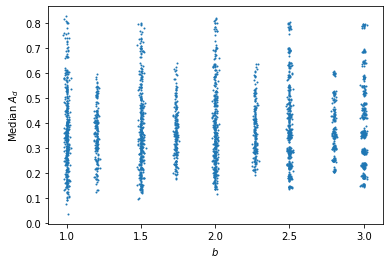

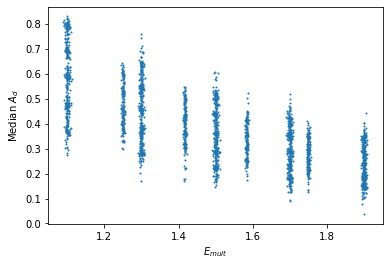

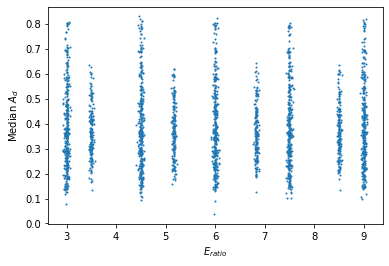

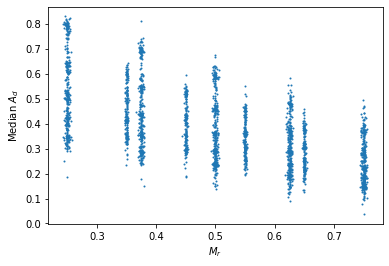

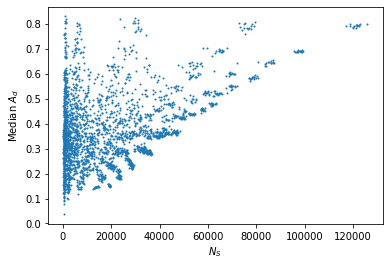

In [7]:
metric = "areal_density_median"
series = stats_df[metric]

for iv in ivs:
    plt.scatter(stats_df[iv], series, s=1)
    plt.xlabel(iv_labels[iv])
    plt.ylabel("Median $A_d$")
    plt.show()

### Distributions Post-Saturation

In [8]:
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage", "n_craters_in_study_region"]
labels = {
    "slope": "$b$",
    "effective_radius_multiplier": "$E_{mult}$",
    "r_stat_multiplier": "$E_{ratio}$",
    "min_rim_percentage": "$M_r$",
    "n_craters_in_study_region": "$N_S$",
    "areal_density": "$A_d$",
    "z": "$Z$",
    "za": "$Z_a$",
}

In [10]:
stats_df = pd.read_csv(f"{base_path}/post_saturation_sample_500.csv")
# stats_df = pd.read_csv(f"{base_path}/post_saturation_sample_5000.csv")

paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))
holdout_sim_dfs = [pd.read_parquet(x) for x in paths]

metrics = ["areal_density", "z", "za"]
metric = "areal_density"
# metric = "za"
# metric = "z"

### Histograms of all simulations combined

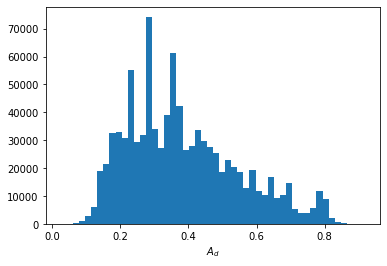

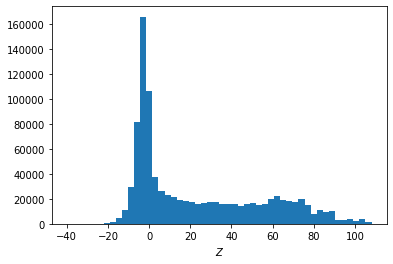

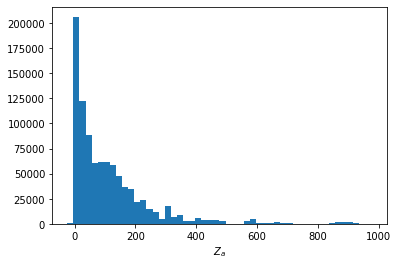

In [11]:
for m in metrics:
    plt.hist(stats_df[m], bins=50)
    plt.xlabel(labels[m])              
    plt.show()

### Histograms of individual simulations

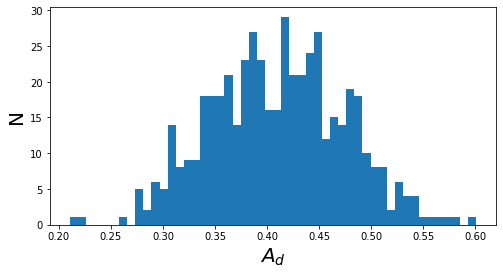

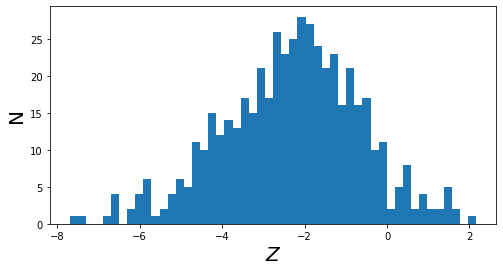

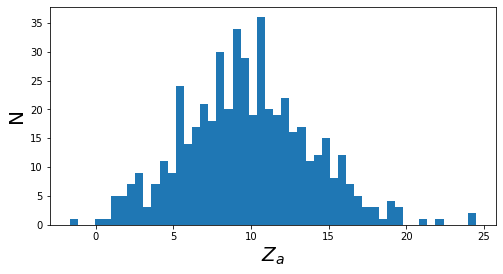

In [20]:
simulation_id = 12
for m in metrics:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.hist(stats_df[stats_df.simulation_id == simulation_id][m], bins=50)
    ax.set_xlabel(labels[m])
    ax.xaxis.label.set_fontsize(20)
    ax.set_ylabel("N")
    ax.yaxis.label.set_fontsize(20)
    
    plt.show()

In [21]:
def plot_four_metric_plots(python_stats: pd.DataFrame,
                           n_craters_column: str,
                           areal_density_column: str,
                           z_column: str,
                           za_column: str,
                           output_filename: str=None,
                           saturation_line: int=None):
    font_size = 20
    
    fig, axes = plt.subplot_mosaic([['(a)', '(b)'], ['(c)', '(d)']],
                               figsize=(14, 7),
                               constrained_layout=True)

    for label, ax in axes.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize=16,
                verticalalignment='top',
                fontfamily='serif',
                bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

    # Plot crater count
    ax = axes['(a)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[n_craters_column], color='b', label='Python')
    if saturation_line:
        ax.axvline(saturation_line, color="r", linestyle="--")
    ax.set_xlabel('$N_G$', fontsize=font_size)
    ax.set_ylabel('$N_S$', fontsize=font_size)

    # Plot crater count
    ax = axes['(b)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[areal_density_column], color='b', label='Python')
    if saturation_line:
        ax.axvline(saturation_line, color="r", linestyle="--")
    ax.set_xlabel('$N_G$', fontsize=font_size)
    ax.set_ylabel('$A_d$', fontsize=font_size)

    # Plot Z statistic
    ax = axes['(c)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[z_column], color='b', label='Python')
    if saturation_line:
        ax.axvline(saturation_line, color="r", linestyle="--")
    ax.set_xlabel('$N_G$', fontsize=font_size)
    ax.set_ylabel('$Z$', fontsize=font_size)

    # Plot Za statistic
    ax = axes['(d)']
    ax.plot(python_stats.n_craters_added_in_study_region, python_stats[za_column], color='b', label='Python')
    if saturation_line:
        ax.axvline(saturation_line, color="r", linestyle="--")
    ax.set_xlabel('$N_G$', fontsize=font_size)
    ax.set_ylabel('$Z_a$', fontsize=font_size)

    if output_filename:
        plt.savefig(output_filename)
        
    plt.show()

In [26]:
slope, effective_radius_multiplier, r_stat_multiplier, min_rim_percentage = stats_df[stats_df.simulation_id == 1234][["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0]
slope, effective_radius_multiplier, r_stat_multiplier, min_rim_percentage

(2.5, 1.3, 4.5, 0.5)

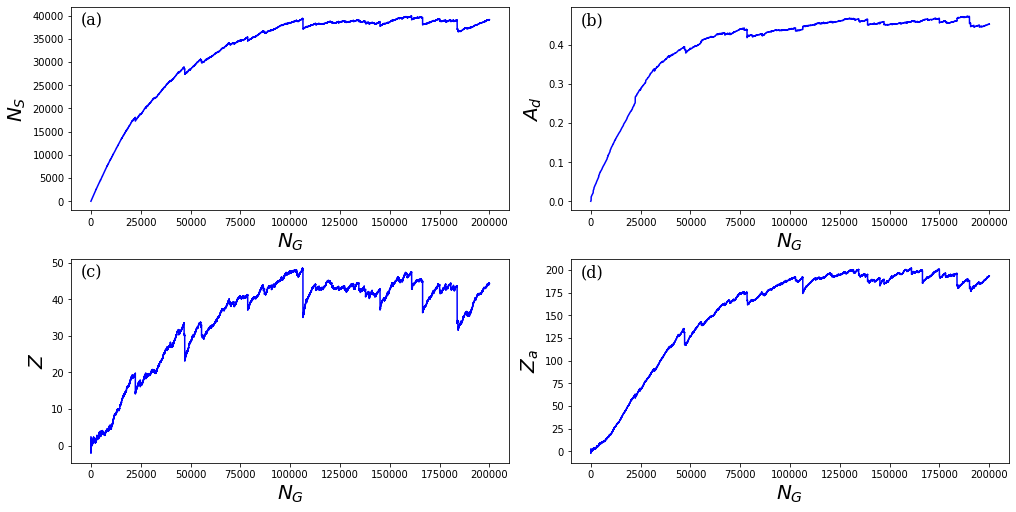

In [27]:
subdir = f"ccd_{effective_radius_multiplier:0.3f}_{min_rim_percentage:0.3f}_{r_stat_multiplier:0.3f}_{slope:0.3f}"
stats_file = f"{base_path}/{subdir}/statistics_100000.parquet"
df = pd.read_parquet(stats_file)

for x in range(4):
    try:
        stats_file = f"{base_path}/{subdir}/statistics_{x + 2}00000.parquet"
        df = pd.concat([df, pd.read_parquet(stats_file)])
    except:
        pass

# df = df[:100000].copy()

plot_four_metric_plots(df,
                       "n_craters_in_study_region",
                       "areal_density",
                       "z",
                       "za")